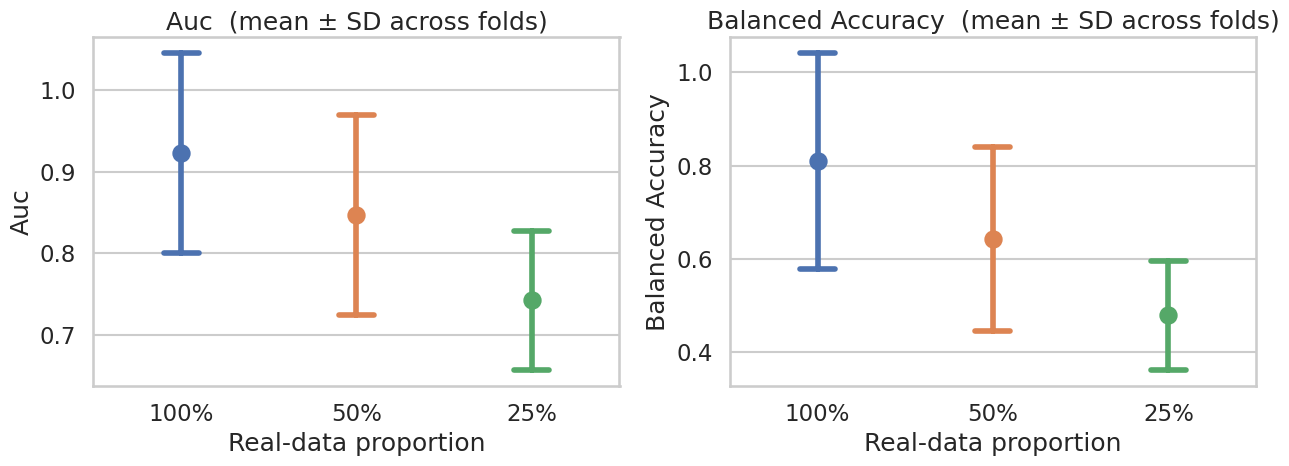

In [1]:
import pandas as pd
from pathlib import Path
import re
import seaborn as sns
import matplotlib.pyplot as plt

# ── editable bits ────────────────────────────────────────────────
seeds = [42, 43, 44, 45, 46]
experiment_folders = [
    *[f"048_resnet50_four_class_pretrainedImagenet_frozenlayers_seed{s}_real_perc1.0" for s in seeds], # 48 - > Real
    *[f"051_resnet50_four_class_pretrainedImagenet_frozenlayers_seed{s}_real_perc0.5" for s in seeds], # 51 - > 50% synthetic
    *[f"052_resnet50_four_class_pretrainedImagenet_frozenlayers_seed{s}_real_perc0.25" for s in seeds], # 52 -> 75% synthetic
    *[f"053_resnet50_four_class_pretrainedImagenet_frozenlayers_seed{s}_real_perc0.0" for s in seeds], # 53 -> 100% synthetic
]

base_dir = Path("experiments")
patience = 20
# ─────────────────────────────────────────────────────────────────

rows = []
for exp in experiment_folders:
    log_csv = base_dir / exp / "logs.csv"
    if not log_csv.exists():
        print(f"⚠  {exp}: logs.csv not found – skipped")
        continue

    df = pd.read_csv(log_csv)
    val_rows = df[df.phase == "val"]

    for fold, g in val_rows.groupby("fold"):
        last_ep   = g["epoch"].max()
        target_ep = max(last_ep - patience, g["epoch"].min())
        rec       = g[g["epoch"] == target_ep].iloc[0]
        rows.append({
            "experiment": exp,
            "fold": int(fold),
            "AUC":  rec["AUC"],
            "balanced_accuracy": rec["balanced_accuracy"]
        })

plot_df = pd.DataFrame(rows)
# Add 'group' column based on the experiment prefix (e.g., 048, 051)
plot_df["group"] = plot_df["experiment"].apply(lambda x: x.split("_")[0])

if plot_df.empty:
    raise RuntimeError("No data collected – check paths / names")
# ── NEW: derive a %-string from “…_real_percX.Y” ───────────────
def perc_label(exp_path: str) -> str:
    """
    Grabs the first 'real_percX.Y' in the string and returns 'XY%'.
    Examples:
        “…real_perc1.0”  ->  '100%'
        “…real_perc0.5”  ->  '50%'
        “…real_perc0.25” ->  '25%'
    """
    m = re.search(r"real_perc([0-9.]+)", exp_path)
    if m:
        pct = float(m.group(1)) * 100
        # Strip trailing '.0' if integer (100.0 → 100)
        pct_str = f"{pct:g}%"
        return pct_str
    return "unknown"

plot_df["real_pct"] = plot_df["experiment"].map(perc_label)

if plot_df.empty:
    raise RuntimeError("No data collected – check paths / names")

# ── plotting ───────────────────────────────────────────────────
sns.set(style="whitegrid", context="talk")
fig, axes = plt.subplots(1, 2, figsize=(13, 5), sharex=True)

for metric, ax in zip(["AUC", "balanced_accuracy"], axes):
    sns.pointplot(
        data      = plot_df,
        x         = "real_pct",    # 100 % · 50 % · 25 %
        y         = metric,
        hue       = "group",       # keep colour coding if you like
        errorbar  = "sd",
        capsize   = .2,
        linestyles = "",
        ax        = ax
    )
    ax.set_title(metric.replace('_', ' ').title() + "  (mean ± SD across folds)")
    ax.set_xlabel("Real-data proportion")
    ax.set_ylabel(metric.replace('_', ' ').title())
    ax.tick_params(axis='x', rotation=0)

    # 1-liner to ditch the legend
    if ax.get_legend() is not None:
        ax.get_legend().remove()

plt.tight_layout()
plt.show()


In [5]:
# ── Compute sensitivity & specificity summaries ─────────────────────────────
import numpy as np
import pandas as pd

class_metrics = [
    "sensitivity_benign", "specificity_benign",
    "sensitivity_malignant", "specificity_malignant",
    "sensitivity_suspicious", "specificity_suspicious",
    "sensitivity_prob_benign", "specificity_prob_benign"
]

metric_rows = []
for exp in experiment_folders:
    log_csv = base_dir / exp / "logs.csv"
    if not log_csv.exists():
        continue

    df = pd.read_csv(log_csv)
    val_rows = df[df.phase == "val"]

    for fold, g in val_rows.groupby("fold"):
        last_ep   = g["epoch"].max()
        target_ep = max(last_ep - patience, g["epoch"].min())
        rec       = g[g["epoch"] == target_ep].iloc[0]

        row = {"experiment": exp, "fold": int(fold), "real_pct": perc_label(exp)}
        row.update({m: rec.get(m, np.nan) for m in class_metrics})
        metric_rows.append(row)

metrics_df = pd.DataFrame(metric_rows)

# ── Aggregate by proportion of real data ────────────────────────────────────
summary_df = (
    metrics_df
    .groupby("real_pct")[class_metrics]
    .agg(['mean', 'std'])
    .round(3)
)

summary_df.columns = [f"{metric}_{stat}" for metric, stat in summary_df.columns]
summary_df = summary_df.reset_index()

# ── 1) Save clean CSV for Excel ------------------------------------------------
csv_path = "./plots_for_paper/sensitivity_specificity_summary.csv"
summary_df.to_csv(csv_path, index=False)
print(f"✓ CSV written to '{csv_path}'")

# ── 2) ALSO print tab-separated table for quick copy-paste --------------------
print("\nCopy-paste friendly (tab-separated):\n")
print(summary_df.to_csv(index=False, sep="\t"))


✓ CSV written to './plots_for_paper/sensitivity_specificity_summary.csv'

Copy-paste friendly (tab-separated):

real_pct	sensitivity_benign_mean	sensitivity_benign_std	specificity_benign_mean	specificity_benign_std	sensitivity_malignant_mean	sensitivity_malignant_std	specificity_malignant_mean	specificity_malignant_std	sensitivity_suspicious_mean	sensitivity_suspicious_std	specificity_suspicious_mean	specificity_suspicious_std	sensitivity_prob_benign_mean	sensitivity_prob_benign_std	specificity_prob_benign_mean	specificity_prob_benign_std
100%	0.922	0.102	0.897	0.148	0.756	0.296	0.983	0.017	0.767	0.271	0.949	0.062	0.795	0.264	0.931	0.083
25%	0.799	0.05	0.634	0.16	0.289	0.184	0.966	0.016	0.429	0.147	0.863	0.037	0.398	0.169	0.871	0.036
50%	0.846	0.07	0.781	0.178	0.535	0.27	0.969	0.017	0.608	0.235	0.894	0.064	0.584	0.255	0.901	0.064



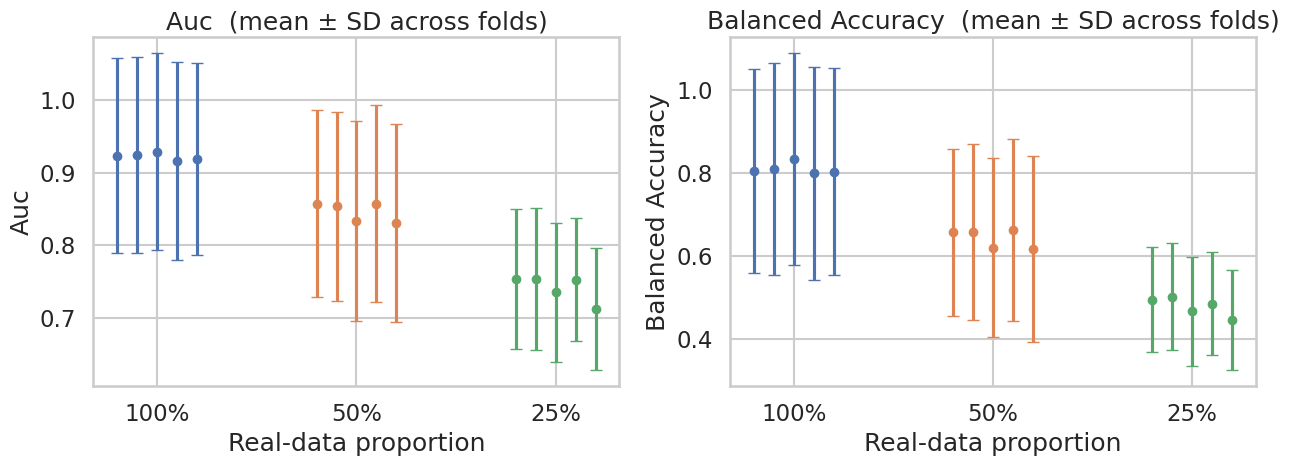

In [10]:
import pandas as pd
from pathlib import Path
import re
import seaborn as sns
import matplotlib.pyplot as plt

# ── editable bits ────────────────────────────────────────────────
seeds = [42, 43, 44, 45, 46]
experiment_folders = [
    *[f"048_resnet50_four_class_pretrainedImagenet_frozenlayers_seed{s}_real_perc1.0" for s in seeds], # 48 - > Real
    *[f"051_resnet50_four_class_pretrainedImagenet_frozenlayers_seed{s}_real_perc0.5" for s in seeds], # 51 - > 50% synthetic
    *[f"052_resnet50_four_class_pretrainedImagenet_frozenlayers_seed{s}_real_perc0.25" for s in seeds], # 52 -> 75% synthetic
]

base_dir = Path("experiments")
patience = 20
# ─────────────────────────────────────────────────────────────────

rows = []
for exp in experiment_folders:
    log_csv = base_dir / exp / "logs.csv"
    if not log_csv.exists():
        print(f"⚠  {exp}: logs.csv not found – skipped")
        continue

    df = pd.read_csv(log_csv)
    val_rows = df[df.phase == "val"]

    for fold, g in val_rows.groupby("fold"):
        last_ep   = g["epoch"].max()
        target_ep = max(last_ep - patience, g["epoch"].min())
        rec       = g[g["epoch"] == target_ep].iloc[0]
        rows.append({
            "experiment": exp,
            "fold": int(fold),
            "AUC":  rec["AUC"],
            "balanced_accuracy": rec["balanced_accuracy"]
        })

plot_df = pd.DataFrame(rows)
# Add 'group' column based on the experiment prefix (e.g., 048, 051)
plot_df["group"] = plot_df["experiment"].apply(lambda x: x.split("_")[0])

if plot_df.empty:
    raise RuntimeError("No data collected – check paths / names")
# ── NEW: derive a %-string from “…_real_percX.Y” ───────────────
def perc_label(exp_path: str) -> str:
    """
    Grabs the first 'real_percX.Y' in the string and returns 'XY%'.
    Examples:
        “…real_perc1.0”  ->  '100%'
        “…real_perc0.5”  ->  '50%'
        “…real_perc0.25” ->  '25%'
    """
    m = re.search(r"real_perc([0-9.]+)", exp_path)
    if m:
        pct = float(m.group(1)) * 100
        # Strip trailing '.0' if integer (100.0 → 100)
        pct_str = f"{pct:g}%"
        return pct_str
    return "unknown"

plot_df["real_pct"] = plot_df["experiment"].map(perc_label)

if plot_df.empty:
    raise RuntimeError("No data collected – check paths / names")

# ── plotting : 5 dots per % (one per seed), same colour per cluster ──────────
import numpy as np

# aggregate: one row = (real_pct, seed) → mean & sd across folds
agg = (
    plot_df
    .groupby(["real_pct", "experiment"])
    .agg({"AUC": ["mean", "std"], "balanced_accuracy": ["mean", "std"]})
    .reset_index()
)
# flatten the MultiIndex columns
agg.columns = ["real_pct", "experiment",
               "AUC_mean", "AUC_sd",
               "BA_mean",  "BA_sd"]

# pull seed out of the experiment string
agg["seed"] = agg["experiment"].str.extract(r"_seed(\d+)_").astype(int)

# Manual colour palette: one colour per %-real cluster
cluster_palette = {"100%": "C0", "50%": "C1", "25%": "C2"}

sns.set(style="whitegrid", context="talk")
fig, axes = plt.subplots(1, 2, figsize=(13, 5), sharex=True)
metric_info = {
    "AUC": ("AUC_mean", "AUC_sd"),
    "balanced_accuracy": ("BA_mean", "BA_sd")
}

x_order = ["100%", "50%", "25%"]          # keep ticks in logical order
x_offsets = np.linspace(-0.2, 0.2, 5)     # five little nudges for the 5 seeds

for ax, (metric, cols) in zip(axes, metric_info.items()):
    mean_col, sd_col = cols

    for i, pct in enumerate(x_order):
        cluster_data = agg[agg["real_pct"] == pct]
        for j, (_, row) in enumerate(cluster_data.iterrows()):
            x = i + x_offsets[j]          # centre at tick i, spread seeds
            y = row[mean_col]
            yerr = row[sd_col]

            ax.errorbar(x, y, yerr,
                        fmt="o", ms=6, capsize=4,
                        color=cluster_palette[pct])

    ax.set_xticks(range(len(x_order)))
    ax.set_xticklabels(x_order)
    ax.set_xlabel("Real-data proportion")
    ax.set_ylabel(metric.replace('_', ' ').title())
    ax.set_title(metric.replace('_', ' ').title() + "  (mean ± SD across folds)")

plt.tight_layout()
plt.show()


# Now do it across repeated experiments

Per-experiment mean metrics (mean over 5 folds):


,AUC,balanced_accuracy
experiment,,
048_resnet50_four_class_pretrainedImagenet_frozenlayers_seed42_real_perc1.0,0.9232,0.8037
048_resnet50_four_class_pretrainedImagenet_frozenlayers_seed43_real_perc1.0,0.9240,0.8105
048_resnet50_four_class_pretrainedImagenet_frozenlayers_seed44_real_perc1.0,0.9290,0.8333
048_resnet50_four_class_pretrainedImagenet_frozenlayers_seed45_real_perc1.0,0.9164,0.7990
048_resnet50_four_class_pretrainedImagenet_frozenlayers_seed46_real_perc1.0,0.9191,0.8033
051_resnet50_four_class_pretrainedImagenet_frozenlayers_seed42_real_perc0.5,0.8576,0.6569
051_resnet50_four_class_pretrainedImagenet_frozenlayers_seed43_real_perc0.5,0.8537,0.6580
051_resnet50_four_class_pretrainedImagenet_frozenlayers_seed44_real_perc0.5,0.8336,0.6194
051_resnet50_four_class_pretrainedImagenet_frozenlayers_seed45_real_perc0.5,0.8576,0.6638



Across-experiment summary:


,AUC,balanced_accuracy
mean_across_experiments,0.8845,0.7266
sd_across_experiments,0.0389,0.0850


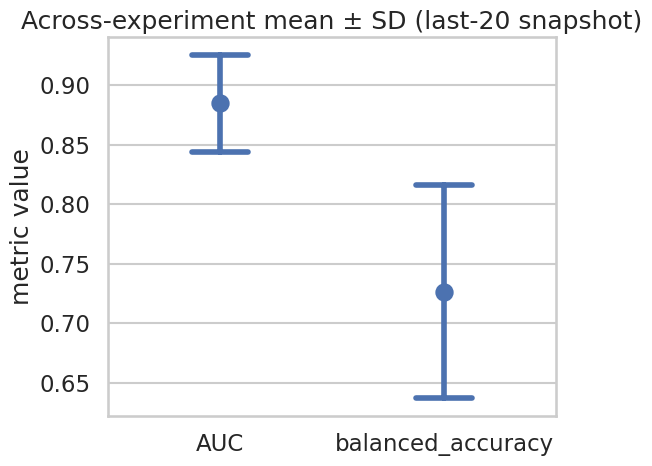

In [17]:
import pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt

# ── edit here ───────────────────────────────────────────────────

seeds = [42, 43, 44, 45, 46]
experiment_folders = [
    *[f"048_resnet50_four_class_pretrainedImagenet_frozenlayers_seed{s}_real_perc1.0" for s in seeds],
    *[f"051_resnet50_four_class_pretrainedImagenet_frozenlayers_seed{s}_real_perc0.5" for s in seeds]
]

base_dir = Path("experiments")
patience = 20                     # last-N rule
# ────────────────────────────────────────────────────────────────

# ----------------------------------------------------------------
# 1. collect one row / experiment (mean of its 5 folds)
# ----------------------------------------------------------------
rows = []
for exp in experiment_folders:
    csv_path = base_dir / exp / "logs.csv"
    if not csv_path.exists():
        print(f"⚠  {exp}: logs.csv not found – skipped")
        continue
    
    df = pd.read_csv(csv_path)
    val_only = df[df.phase == "val"]
    
    # pick the line that is (last_epoch - patience) for every fold
    picks = []
    for fold, g in val_only.groupby("fold"):
        last_ep   = g["epoch"].max()
        target_ep = max(last_ep - patience, g["epoch"].min())
        picks.append(g[g["epoch"] == target_ep])

    fold_df = pd.concat(picks, ignore_index=True)
    metrics = fold_df[["AUC", "balanced_accuracy"]].mean()
    
    rows.append({"experiment": exp, **metrics.to_dict()})

exp_means = (
    pd.DataFrame(rows)
      .set_index("experiment")
      .round(4)
)

# ----------------------------------------------------------------
# 2. show tables
# ----------------------------------------------------------------
print("Per-experiment mean metrics (mean over 5 folds):")
display(exp_means)

summary = pd.concat(
    [exp_means.mean().to_frame("mean_across_experiments").T,
     exp_means.std(ddof=0).to_frame("sd_across_experiments").T]
).round(4)
print("\nAcross-experiment summary:")
display(summary)

# ----------------------------------------------------------------
# 3. point-plots – one dot per metric (AUC / bal-acc), bar = ±SD
# ----------------------------------------------------------------
long_df = (
    exp_means.reset_index()
             .melt(id_vars="experiment",
                   value_vars=["AUC", "balanced_accuracy"],
                   var_name="metric", value_name="value")
)

sns.set(style="whitegrid", context="talk")
plt.figure(figsize=(6, 5))
sns.pointplot(
    data=long_df,
    x="metric", y="value",
    estimator="mean", errorbar="sd", capsize=.25, linestyles=""
)
plt.title("Across-experiment mean ± SD (last-20 snapshot)")
plt.xlabel("")
plt.ylabel("metric value")
plt.tight_layout()
plt.show()
